This notebook is intended to do a proof of concept plots where cells are plotted as their segmentation masks. Currently not far, trying to map cells to their segmentation mask.

In [1]:
import squidpy as sq
import scanpy as sc

import numpy as np, pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
import xarray as xr

import datashader as ds
from datashader import transfer_functions as tf

# Data

In [3]:
adata = sq.datasets.mibitof()

In [4]:
imgs = []
for library_id in adata.uns["spatial"].keys():
    img = sq.im.ImageContainer(adata.uns["spatial"][library_id]["images"]["hires"], library_id=library_id)
    img.add_img(adata.uns["spatial"][library_id]["images"]["segmentation"], library_id=library_id, layer="segmentation")
    img["segmentation"].attrs["segmentation"] = True
    imgs.append(img)
img = sq.im.ImageContainer.concat(imgs)

In [5]:
segmentation = img["segmentation"]
segmentation

<xarray.DataArray 'segmentation' (y: 1024, x: 1024, z: 3, channels_0: 1)>
array([[[[   1],
         [   1],
         [   1]],

        [[   1],
         [   1],
         [   1]],

        [[   1],
         [   1],
         [   1]],

        ...,

        [[1082],
         [   1],
         [ 951]],

        [[1082],
         [   1],
...
         [  31],
         [  22]],

        [[  20],
         [  31],
         [  22]],

        ...,

        [[   1],
         [1470],
         [1133]],

        [[   1],
         [1470],
         [1133]],

        [[   1],
         [1470],
         [1133]]]], dtype=uint16)
Coordinates:
  * z        (z) <U7 'point16' 'point23' 'point8'
Dimensions without coordinates: y, x, channels_0
Attributes:
    segmentation:  True

In [6]:
adata_p16 = adata[adata.obs["library_id"] == "point16"].copy()
seg_p16 = img["segmentation"].sel({"z": "point16", "channels_0": 0})

In [7]:
adata_p16

AnnData object with n_obs × n_vars = 1023 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'batch', 'library_id'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2'
    uns: 'Cluster_colors', 'batch_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [8]:
seg_p16

<xarray.DataArray 'segmentation' (y: 1024, x: 1024)>
array([[   1,    1,    1, ..., 1082, 1082, 1082],
       [   1,    1,    1, ..., 1082, 1082, 1082],
       [   1,    1,    1, ..., 1082, 1082, 1082],
       ...,
       [  20,   20,   20, ...,    1,    1,    1],
       [  20,   20,   20, ...,    1,    1,    1],
       [  20,   20,   20, ...,    1,    1,    1]], dtype=uint16)
Coordinates:
    z        <U7 'point16'
Dimensions without coordinates: y, x
Attributes:
    segmentation:  True

## Some stats

In [9]:
adata.obs.groupby("library_id")["cell_id"].apply(lambda x: len(x.unique()))

library_id
point16    1023
point23    1241
point8     1045
Name: cell_id, dtype: int64

In [10]:
segmentation.max(dim=["x", "y"])

<xarray.DataArray 'segmentation' (z: 3, channels_0: 1)>
array([[1107],
       [1483],
       [1181]], dtype=uint16)
Coordinates:
  * z        (z) <U7 'point16' 'point23' 'point8'
Dimensions without coordinates: channels_0

In [11]:
for i in range(segmentation.shape[2]):
    print(len(np.unique(segmentation[:, :, i])))

1108
1484
1182


In [12]:
adata.obs.groupby("library_id").apply(lambda x: len(x))

library_id
point16    1023
point23    1241
point8     1045
dtype: int64

# Basic vis

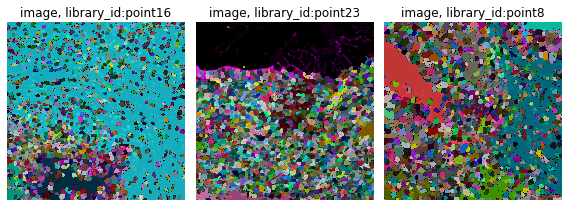

In [13]:
img.show("image", segmentation_layer="segmentation")

In [14]:
color_array = mpl.colors.to_rgba_array(adata.uns["Cluster_colors"])

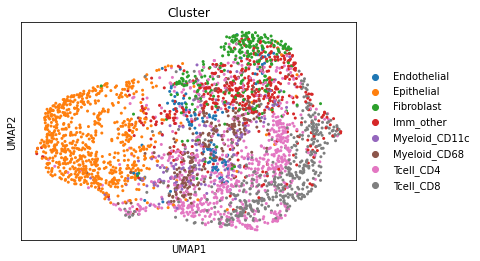

In [15]:
sc.pl.umap(adata, color="Cluster")

# Datashader plotting using segmentation masks

In [16]:
def get_cluster_colors(adata, key):
    return dict(
        zip(
            adata.obs[key].cat.categories, 
            adata.uns[f"{key}_colors"]
        )
    )

In [17]:
def coord_df(adata, seg, col) -> pd.DataFrame:
    """
    Params
    ------
    adata
        AnnData subset to relevant library_id
    seg
        Seg is the segmentation mask for this anndata and library_id
    col
        Column from anndata to use for plotting.
        
    Returns
    -------
    Dataframe with columns: "x", "y", and col. Maps each pixel from seg to it's value from adata.
    
    Notes
    -----
    
    * Assumes segmentation masks are non-overlapping.
    """
    return (
        seg.to_dataframe()
        ["segmentation"]
        .map(
            sc.get.obs_df(adata, [col, "cell_id"])
            .set_index("cell_id")
            .squeeze()
        )
        .dropna()
        .reset_index()
        .rename(columns={"segmentation": col})
    )

In [18]:
coords = coord_df(adata_p16, seg_p16, "Cluster")
coords

,y,x,Cluster
0,0,58,Imm_other
1,0,59,Imm_other
2,0,60,Imm_other
3,0,61,Imm_other
4,0,62,Imm_other
...,...,...,...
351402,1023,990,Imm_other
351403,1023,991,Imm_other
351404,1023,992,Imm_other
351405,1023,993,Imm_other


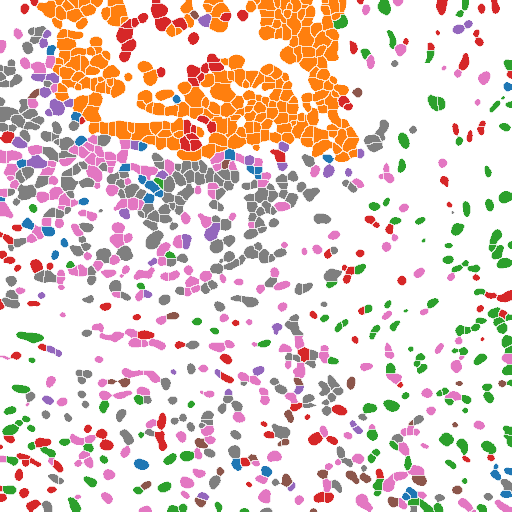

In [19]:
tf.shade(
    (
        ds.Canvas(512, 512)
        .points(coords, "x", "y", agg=ds.count_cat("Cluster"))
    ),
    color_key=get_cluster_colors(adata_p16, "Cluster"),
)

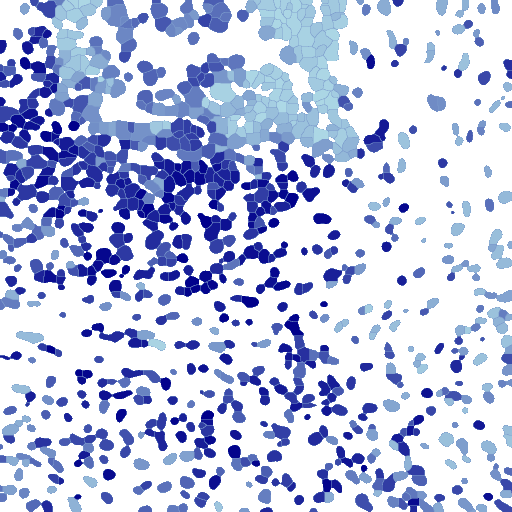

In [20]:
tf.shade(
    ds.Canvas(512, 512)
    .points(coord_df(adata_p16, seg_p16, "CD45"), "x", "y", agg=ds.sum("CD45"))
)

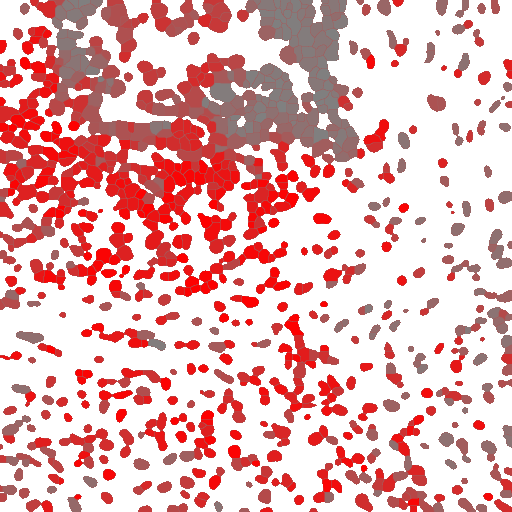

In [21]:
tf.shade(
    (
        ds.Canvas(512, 512)
        .points(coord_df(adata_p16, seg_p16, "CD45"), "x", "y", agg=ds.sum("CD45"))
    ),
    cmap=["gray", "red"]
)

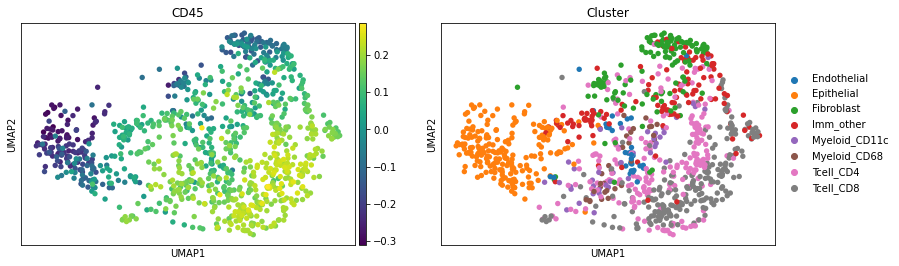

In [22]:
sc.pl.umap(adata_p16, color=["CD45", "Cluster"])

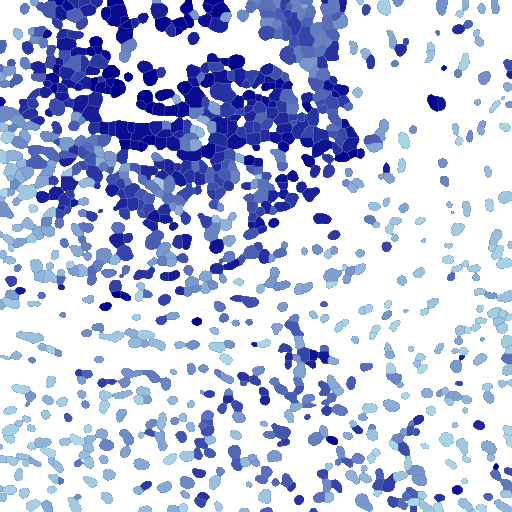

In [23]:
tf.shade(
    ds.Canvas(512, 512)
    .points(coord_df(adata_p16, seg_p16, "CD98"), "x", "y", agg=ds.sum("CD98"))
)

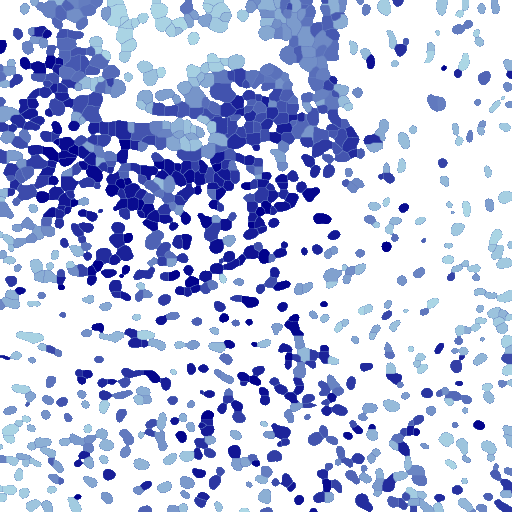

In [24]:
tf.shade(
    ds.Canvas(512, 512)
    .points(coord_df(adata_p16, seg_p16, "CD4"), "x", "y", agg=ds.sum("CD4"))
)

# Version info

In [25]:
sc.logging.print_versions()

-----
anndata     0.7.7.dev4+g49739eb
scanpy      1.9.0.dev12+g99d74741.d20210805
sinfo       0.3.1
-----
Cython                      0.29.24
PIL                         8.3.1
PyQt5                       NA
anndata                     0.7.7.dev4+g49739eb
anyio                       NA
appnope                     0.1.0
asciitree                   NA
attr                        21.2.0
babel                       2.8.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2020.06.20
cffi                        1.14.0
chardet                     3.0.4
charset_normalizer          2.0.6
click                       8.0.3
cloudpickle                 1.6.0
colorama                    0.4.4
cycler                      0.10.0
cython                      0.29.24
cython_runtime              NA
dask                        2021.09.1
dask_image                  0.6.0
datashader                  0.13